In [ ]:
import os
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from d2l import torch as d2l

### Main reference: https://www.d2l.com/

# Semantic Segmentation with Modern Convolutional Neural Networks

- **Modern Convolutional Neural Networks**

    - **Depth**: From LeNet (1995) to AlexNet (2012)
    
    - **Blocks**: From AlexNet to VGG (2014)
    
    - **1x1 Convolutions** and **Global Average Pooling**: from VGG to NiN and GoogLeNet (2015) 
    
    - **Batch Normalization** and **Residual Connections**: From GoogLeNet to ResNet (2016)

- **Image Segmentation**

    - The Pascal VOC2012 Dataset

    - Image Augmentation

    - **Transposed Convolutions**

    - The (Fully Convolutional) Segmentation Model

    - Training and Prediction

# Modern Convolutional Neural Networks


## Basics of Convolutions

Convolutions are the key element to design neural network architectures that satisfy the requirements for computer vision applications:

-  **Translation Invariance**: In the earliest layers, the network should respond similarly to the same patch    regardless of where it appears in the image.

-  **Locality**: In the earliest layers, the network should respond to local, small scale features.

-  **Hierarchical Feature Extraction**: Deeper layers layers should be able to aggregate local featurs into more complex, longer-range features.

A convolutional operation is specified by 5 main parameters:

-   Input channels

-   Output channels

-   Kernel size

-   Padding

-   Stride

Simple convolutional operation

![Two-dimensional cross-correlation operation. The shaded portions are the first output element as well as the input and kernel tensor elements used for the output computation: $0\times0+1\times1+3\times2+4\times3=19$.](pytorch/img/correlation.svg)

Convolution with padding and stride

![Two-dimensional cross-correlation with padding.](pytorch/img/conv-pad.svg)

![Cross-correlation with strides of 3 and 2 for height and width, respectively.](pytorch/img/conv-stride.svg)

Convolutional operations change input size according to the formula:

$$\lfloor(n_h-k_h+p_h+s_h)/s_h\rfloor \times \lfloor(n_w-k_w+p_w+s_w)/s_w\rfloor.$$

You can play with the code below to check how convolutions manipulate the dimensions of the input:

In [ ]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
X, K = X.reshape(1, 1, 3, 3), K.reshape(1, 1, 2, 2)


conv2d = nn.Conv2d(1, 1, kernel_size=2, padding=1, stride=(3, 2), bias=False)
conv2d.weight.data = K

conv2d(X), conv2d(X).shape

## **Depth**: From LeNet (1995) to AlexNet (2012)

### LeNet (1995)

- *LeNet* was introduced by (and named for) Yann LeCun, then a researcher at AT&T Bell Labs.

    - The purpose was recognizing handwritten digits in images.

- It was the culmination of a decade of research developing the technology.

    - In 1989, LeCun's team published the first study to successfully train CNNs via backpropagation.


- For the time, LeNet achieved outstanding results

    - It achieved an error rate of less than 1% per digit on the famous MNIST dataset.

LeNet architecture:

![Compressed notation for LeNet-5.](pytorch/img/lenet-vert.svg)

- In 1995, implementing LeNet would take years of work for a group of highly-skilled computer scientists.

- In 2022, we can implement LeNet with modern deep learning frameworks with a few lines of code:

In [ ]:
class LeNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes))

LeNet model inspection:

In [ ]:
@d2l.add_to_class(d2l.Classifier)  #@save
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = LeNet()
model.layer_summary((1, 1, 28, 28))

Training LeNet:

- We use d2l library to wrap dataloaders and training routines into useful routines.

    - The structure used by d2l is similar to other popular frameworks (for example Pytorch Lightning).

In [ ]:
def init_cnn(module):  #@save
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = LeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

### AlexNet (2012)

- AlexNet was the first CNN to achieve state-of-the-art results in computer vision tasks.

- Before AlexNet, the focus in computer vision was the engineering and extraction of features. The classifier was an afterthought.
    
    - OpenCV still offers popular feature extraction pipelines, such as SIFT and SURF

- With AlexNet, CNNs started to dominate the field of computer vision exploiting fully learned features.

AlexNet architecture:

![From LeNet (left) to AlexNet (right).](pytorch/img/alexnet.svg)

- Implementing AlexNet (in 2012) was also an engineering challenge.

In [ ]:
class AlexNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(96, kernel_size=11, stride=4, padding=1),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(256, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(4096), nn.ReLU(),nn.Dropout(p=0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

AlexNet model inspection

In [ ]:
AlexNet().layer_summary((1, 1, 224, 224))

- LeNet versus AlexNet:

    - AlexNet is deeper (11 versus 5 layers) and wider (hundred versus dozens of channels).
    
    - It uses ReLu versus  Sigmoid activations.

    - It added Dropout as regularizer.

    - It uses Max Pooling versus Average Pooling.

    - It relied heavily on data augmentation to avoid overfitting.

- AlexNet breakthrough was enabled by technological (available data and compute), rather than theoretical and conceptual advances.

- AlexNet is effectively the first *deep* CNN.

Training LeNet:

In [ ]:
model = AlexNet(lr=0.01)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
trainer.fit(model, data)

## **Blocks**: VGG (2014)

- Before VGG was introduced, architure design focused on the fundamental building blocks (neurons and layers).

- With VGG network architecture design shifted to repeating patterns (blocks, or groups of layers).

    - It is common nowadays to think of architectures in terms of entire, pre-trained models.

- The common pattern in CNNs before VGG:

    - (i) a convolutional layer with padding to maintain the resolution.

    - (ii) a nonlinearity such as a ReLU.

    - (iii) a pooling layer such as max-pooling to reduce the resolution.
     
- In the case of ImageNet, it would be impossible to have 
more than 8 convolutional layers in this way. 


VGG architecture:

![From AlexNet to VGG. The key difference is that VGG consists of blocks of layers, whereas AlexNet's layers are all designed individually.](pytorch/img/vgg.svg)

- Some key advantages of the VGG block: 

    - The successive application of two $3 \times 3$ convolutions
touches the same pixels as a single $5 \times 5$ convolution does (same receptive field).

    - At the same time, the latter uses approximately as many parameters ($25 \cdot c^2$) as three $3 \times 3$ convolutions do ($3 \cdot 9 \cdot c^2$).

    - Stacking $3 \times 3$ convolutions was, for some time, the gold standard in later deep networks

VGG block:

In [ ]:
def vgg_block(num_convs, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

VGG architecture family:

In [ ]:
class VGG(d2l.Classifier):
    def __init__(self, arch, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        conv_blks = []
        for (num_convs, out_channels) in arch:
            conv_blks.append(vgg_block(num_convs, out_channels))
        self.net = nn.Sequential(
            *conv_blks, nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

The original VGG network (VGG-11) has 8 convolutional and 3 fully conneted layers:

In [ ]:
VGG(arch=((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))).layer_summary(
    (1, 1, 224, 224))

Training a shallower version of VGG-11:

In [ ]:
model = VGG(arch=((1, 16), (1, 32), (2, 64), (2, 128), (2, 128)), lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

## **1x1 Convolutions** and **Global Average Pooling**: NiN (Network in Network) and GoogLeNet

- AlexNet and VGG share a design with two major challenges:

    - First, the fully connected layers at the end of the architecture consume tremendous numbers of parameters. VGG-11 requires a monstrous $25088 \times 4096$ matrix, occupying almost 400MB of RAM.

    - Second, it is equally impossible to add fully connected layers earlier in the network to increase the degree of nonlinearity.

- The Network in Network (NiN) blocks solved both problems in one simple strategy:

    - Use $1 \times 1$ convolutions to add local non-linearities across the channel activations.
    
    - Use global average pooling to integrate across all locations in the last representation layer. 

- GoogLeNet used similar ingredients to achieve better esults with the famous **Inception** block.

### 1x1 Convolutions

- A $1\times 1$ convolutional layer is like a fully connected layer applied at every single pixel location:

    - It transform the $c_i$ input channels into $c_o$ output channels.

    - The weights are tied across pixel location.

    - Convolutional layers are typically followed by nonlinearities. This ensures that $1 \times 1$ convolutions cannot simply be folded into other convolutions. 

![The cross-correlation computation uses the $1\times 1$ convolution kernel with 3 input channels and 2 output channels. The input and output have the same height and width.](pytorch/img/conv-1x1.svg)

In [ ]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
X = X.reshape(1, 1, 3, 3)


conv2d = nn.Conv2d(1, 10, kernel_size=1, padding=0, stride=1)

X.shape, conv2d(X).shape

### Global Average Pooling

- Global Average Pooling is simply an Average pooling operation that reduces the size of spatial dimensions to $1$

In [ ]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
X = X.reshape(1, 1, 3, 3)


globavgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

X, globavgpool(X)

### The NiN Network

![Comparing the architectures of VGG and NiN, and of their blocks.](pytorch/img/nin.svg)

- NiN uses a last NiN block with a number of output channels equal to the number of label classes, followed by a global average pooling layer.

- It avoids the final fully connected layers altogether.

NiN Block:

In [ ]:
def nin_block(out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.LazyConv2d(out_channels, kernel_size, strides, padding), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU())

NiN architecture: 

In [ ]:
class NiN(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nin_block(96, kernel_size=11, strides=4, padding=0),
            nn.MaxPool2d(3, stride=2),
            nin_block(256, kernel_size=5, strides=1, padding=2),
            nn.MaxPool2d(3, stride=2),
            nin_block(384, kernel_size=3, strides=1, padding=1),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(0.5),
            nin_block(num_classes, kernel_size=3, strides=1, padding=1),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten())
        self.net.apply(d2l.init_cnn)

NiN model inspection:

In [ ]:
model = NiN()
X = torch.randn(1, 1, 224, 224)
for layer in model.net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Training NiN

In [ ]:
model = NiN(lr=0.05)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

### GoogLeNet: the Inception block

![Structure of the Inception block.](pytorch/img/inception.svg)

## **Batch Normalization** and **Residual Connections**: ResNets (2015)

The comined used of batch normalization and residual network allowed training of very deep networks (with over 100 layers).

### Batch Normalization (BN)

- BN normalizes the value of the activations of the layer to which it is applied (zero mean and unit variance).

    - This helps stabilize the training by reducing the risk of underflow/overlfow.

    - It keeps activation values along the network within the same value range.

- BN introduces some noise that acts as a beneficial regularization.

Denote by $\mathcal{B}$ a minibatch and let $\mathbf{x} \in \mathcal{B}$ be an input to 
batch normalization ($\mathrm{BN}$). In this case the batch normalization is defined as follows:

$$\mathrm{BN}(\mathbf{x}) = \boldsymbol{\gamma} \odot \frac{\mathbf{x} - \hat{\boldsymbol{\mu}}_\mathcal{B}}{\hat{\boldsymbol{\sigma}}_\mathcal{B}} + \boldsymbol{\beta}.$$

where $\hat{\boldsymbol{\mu}}_\mathcal{B}$ is the  sample mean
and $\hat{\boldsymbol{\sigma}}_\mathcal{B}$ is the sample standard deviation of the minibatch $\mathcal{B}$.

$$\hat{\boldsymbol{\mu}}_\mathcal{B} = \frac{1}{|\mathcal{B}|} \sum_{\mathbf{x} \in \mathcal{B}} \mathbf{x}
\text{ and }
\hat{\boldsymbol{\sigma}}_\mathcal{B}^2 = \frac{1}{|\mathcal{B}|} \sum_{\mathbf{x} \in \mathcal{B}} (\mathbf{x} - \hat{\boldsymbol{\mu}}_{\mathcal{B}})^2 + \epsilon.$$

The estimates $\hat{\boldsymbol{\mu}}_\mathcal{B}$ and ${\hat{\boldsymbol{\sigma}}_\mathcal{B}}$ counteract the scaling issue
by using noisy estimates of mean and variance.

- BN layers function differently in *training mode* (normalizing by minibatch statistics) and in *prediction mode* (normalizing by dataset statistics).

- Empirically BN works best for moderate minibatches sizes in the $50 \sim 100$ range.

### BN for convolutional layers

- In convolutional layers BN operates on a per-channel basis *across all locations*.

    - This is compatible with our assumption of translation
invariance.

- Assume that our minibatches contain $m$ examples
and that for each channel,
the output of the convolution has height $p$ and width $q$.

    - For convolutional layers, we carry out each batch normalization
over the $m \cdot p \cdot q$ elements per output channel simultaneously.

    - Each channel has its own scale and shift parameters,
both of which are scalars.

Explicit implementation of batch normalization:

In [ ]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # Use `is_grad_enabled` to determine whether we are in training mode
    if not torch.is_grad_enabled():
        # In prediction mode, use mean and variance obtained by moving average
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # When using a fully connected layer, calculate the mean and
            # variance on the feature dimension
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # When using a two-dimensional convolutional layer, calculate the
            # mean and variance on the channel dimension (axis=1). Here we
            # need to maintain the shape of `X`, so that the broadcasting
            # operation can be carried out later
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # In training mode, the current mean and variance are used
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # Update the mean and variance using moving average
        moving_mean = (1.0 - momentum) * moving_mean + momentum * mean
        moving_var = (1.0 - momentum) * moving_var + momentum * var
    Y = gamma * X_hat + beta  # Scale and shift
    return Y, moving_mean.data, moving_var.data

In [ ]:
class BatchNorm(nn.Module):
    # `num_features`: the number of outputs for a fully connected layer
    # or the number of output channels for a convolutional layer. `num_dims`:
    # 2 for a fully connected layer and 4 for a convolutional layer
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # The scale parameter and the shift parameter (model parameters) are
        # initialized to 1 and 0, respectively
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # The variables that are not model parameters are initialized to 0 and
        # 1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # If `X` is not on the main memory, copy `moving_mean` and
        # `moving_var` to the device where `X` is located
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # Save the updated `moving_mean` and `moving_var`
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.1)
        return Y

### LeNet with batch normalization

- BN typically allows for much larger learning rates.

    - Experiment comparing with the original LeNet.

In [ ]:
class BNLeNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5), nn.LazyBatchNorm2d(),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.LazyBatchNorm2d(),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(), nn.LazyLinear(120), nn.LazyBatchNorm1d(),
            nn.Sigmoid(), nn.LazyLinear(84), nn.LazyBatchNorm1d(),
            nn.Sigmoid(), nn.LazyLinear(num_classes))

Training LeNet with BN:

In [ ]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = BNLeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

### Residual Blocks

- Designing deeper networks seems an obvious direction to make them more powerful.

- How can we make sure that adding layers makes networks strictly more expressive rather than just different?

![For non-nested function classes, a larger (indicated by area) function class does not guarantee to get closer to the "truth" function ($f^*$). This does not happen in nested function classes.](pytorch/img/functionclasses.svg)

- For deep neural networks, if we can train the newly-added layer into an identity function $f(\mathbf{x}) = \mathbf{x}$, the new model will be as effective as the original model.

    - The added layer might make it easier to reduce training errors.


Residual connection:

![In a regular block (left), the portion within the dotted-line box must directly learn the mapping $f(\mathbf{x})$. In a residual block (right), the portion within the dotted-line box needs to learn the residual mapping $g(\mathbf{x}) = f(\mathbf{x}) - \mathbf{x}$, making the identity mapping $f(\mathbf{x}) = \mathbf{x}$ easier to learn.](pytorch/img/residual-block.svg)

- Key observations:

    - We want to include the identity function $f(\mathbf{x}) = \mathbf{x}$ in the set of easily trainable/initializable function.

    - Without residual conenction: non-trivial/difficult.

    - With residual connection: trivial/easy, learn/set all the weight and biases equal zero .

Residual block:

![ResNet block with and without $1 \times 1$ convolution, which transforms the input into the desired shape for the addition operation.](pytorch/img/resnet-block.svg)

In [ ]:
class Residual(nn.Module):  #@save
    """The Residual block of ResNet."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

### The ResNet Model

- As it is common with modern architectures, ResNet has three disinct parts:

    - The stem, the body or backbone, and the head.

![The ResNet-18 architecture.](pytorch/img/resnet18-90.svg)

The head is similar to the architectures we have seen before:

In [ ]:
class ResNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

The body is a series of residual blocks:

In [ ]:
@d2l.add_to_class(ResNet)
def block(self, num_residuals, num_channels, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels))
    return nn.Sequential(*blk)

The head is similar to NiN, with the addition of a last fully connected layer:

In [ ]:
@d2l.add_to_class(ResNet)
def __init__(self, arch, lr=0.1, num_classes=10):
    super(ResNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, b in enumerate(arch):
        self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
    self.net.add_module('last', nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)

We can intantiate a ResNet-18 model as follows:

In [ ]:
class ResNet18(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)),
                       lr, num_classes)

ResNet model inspection:

In [ ]:
ResNet18().layer_summary((1, 1, 96, 96))

In [ ]:
ResNet18().layer_summary((1, 1, 128, 128))

Training ResNet

In [ ]:
model = ResNet18(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

# Semantic Segmentation

- Divide an image into regions belonging to different semantic classes.

- Labeling and prediction of semantic regions is at the pixel level.

![Labels of the dog, cat, and background of the image in semantic segmentation.](pytorch/img/segmentation.svg)

## The Pascal VOC2012 Dataset

- Pascal VOC2012 is one of th emost important semantic segmentation datasets.

- Let's download it (it's 2GB, so we pre-downloaded it).

In [43]:
#@save
d2l.DATA_HUB['voc2012'] = (d2l.DATA_URL + 'VOCtrainval_11-May-2012.tar',
                           '4e443f8a2eca6b1dac8a6c57641b67dd40621a49')

voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')

- We can inspect the dataset directly in the stored folder, or using the following handy function: 

In [44]:
#@save
def read_voc_images(voc_dir, is_train=True):
    """Read all VOC feature and label images."""
    txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation',
                             'train.txt' if is_train else 'val.txt')
    mode = torchvision.io.image.ImageReadMode.RGB
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    features, labels = [], []
    for i, fname in enumerate(images):
        features.append(torchvision.io.read_image(os.path.join(
            voc_dir, 'JPEGImages', f'{fname}.jpg')))
        labels.append(torchvision.io.read_image(os.path.join(
            voc_dir, 'SegmentationClass' ,f'{fname}.png'), mode))
    return features, labels

train_features, train_labels = read_voc_images(voc_dir, True)

- Labels are themselves images.

- Each category is encoded as a different color.

    - The color code is only for visualization purposes, it is not used for training.

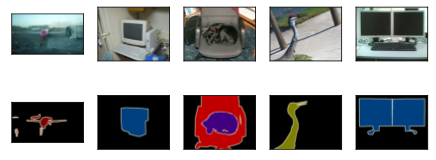

In [46]:
n = 5
imgs = train_features[:n] + train_labels[:n]
imgs = [img.permute(1,2,0) for img in imgs]
d2l.show_images(imgs, 2, n);

Color code and classes:

In [47]:
#@save
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

#@save
VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

Functions that build the mapping from RGB color values to class indices are always useful when working in semantic segmentation:

In [48]:
#@save
def voc_colormap2label():
    """Build the mapping from RGB to class indices for VOC labels."""
    colormap2label = torch.zeros(256 ** 3, dtype=torch.long)
    for i, colormap in enumerate(VOC_COLORMAP):
        colormap2label[
            (colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i
    return colormap2label

#@save
def voc_label_indices(colormap, colormap2label):
    """Map any RGB values in VOC labels to their class indices."""
    colormap = colormap.permute(1, 2, 0).numpy().astype('int32')
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256
           + colormap[:, :, 2])
    return colormap2label[idx]

For example for the first image of the dataset:

In [49]:
y = voc_label_indices(train_labels[0], voc_colormap2label())
y[105:115, 130:140], VOC_CLASSES[0], VOC_CLASSES[1]

(tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]]),
 'background',
 'aeroplane')

## Image Augmentation


- The segmentation network will likely be designed to work best with a given size for the input images.

- Best practice in semantic segmentation is to crop both images and labels.

In [52]:
#@save
def voc_rand_crop(feature, label, height, width):
    """Randomly crop both feature and label images."""
    rect = torchvision.transforms.RandomCrop.get_params(
        feature, (height, width))
    feature = torchvision.transforms.functional.crop(feature, *rect)
    label = torchvision.transforms.functional.crop(label, *rect)
    return feature, label

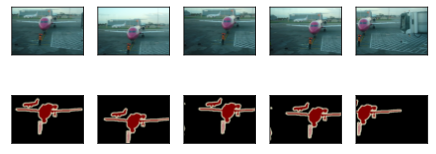

In [53]:
imgs = []
for _ in range(n):
    imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)

imgs = [img.permute(1, 2, 0) for img in imgs]
d2l.show_images(imgs[::2] + imgs[1::2], 2, n);

- The random cropping performed is more like a form of data pre-processing.

- Try to add some more typical augmentations to the input images.

    - Normalization is used in the following custom dataset object.

In [55]:
#@save
class VOCSegDataset(torch.utils.data.Dataset):
    """A customized dataset to load the VOC dataset."""

    def __init__(self, is_train, crop_size, voc_dir):
        self.transform = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.crop_size = crop_size
        features, labels = read_voc_images(voc_dir, is_train=is_train)
        self.features = [self.normalize_image(feature)
                         for feature in self.filter(features)]
        self.labels = self.filter(labels)
        self.colormap2label = voc_colormap2label()
        print('read ' + str(len(self.features)) + ' examples')

    def normalize_image(self, img):
        return self.transform(img.float() / 255)

    def filter(self, imgs):
        return [img for img in imgs if (
            img.shape[1] >= self.crop_size[0] and
            img.shape[2] >= self.crop_size[1])]

    def __getitem__(self, idx):
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx],
                                       *self.crop_size)
        return (feature, voc_label_indices(label, self.colormap2label))

    def __len__(self):
        return len(self.features)

We need to instantiate the train and val datasets

In [56]:
crop_size = (320, 480)
voc_train = VOCSegDataset(True, crop_size, voc_dir)
voc_test = VOCSegDataset(False, crop_size, voc_dir)

read 1114 examples
read 1078 examples


- Setting the batch size to 64, we define the data iterator for the training set.

    - Let's print the shape of the first minibatch.

In [57]:
batch_size = 64
num_workers = d2l.get_dataloader_workers()

train_iter = torch.utils.data.DataLoader(
        VOCSegDataset(True, crop_size, voc_dir), batch_size,
        shuffle=True, drop_last=True, num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(
        VOCSegDataset(False, crop_size, voc_dir), batch_size,
        drop_last=True, num_workers=num_workers)

for X, Y in train_iter:
    print(X.shape)
    print(Y.shape)
    break

read 1114 examples
read 1078 examples
torch.Size([64, 3, 320, 480])
torch.Size([64, 320, 480])


## **Transposed Convolutions**

-  Convolutional and pooling layers in CNN reduce spatial dimensions of the input (dwonsample).

- The output of a semantic segmentation model needs to classify at pixel-level, must have same dimensions as the input.

- To bring back intermediate feature maps to the input dimensions (upsample) we need another type of convolution, the transposed convolution.

### Basic Operation of Transposed Convolutions

- In contrast to the regular convolution that *reduces* input elements via the kernel, the transposed convolution *broadcasts* input elements via the kernel, thereby producing an output that is larger than the input.

![Transposed convolution with a $2\times 2$ kernel. The shaded portions are a portion of an intermediate tensor as well as the input and kernel tensor elements used for the  computation.](pytorch/img/trans_conv.svg)

Transposed Convolution in code:

In [58]:
X = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])

In [59]:
X, K = X.reshape(1, 1, 2, 2), K.reshape(1, 1, 2, 2)
tconv = nn.ConvTranspose2d(1, 1, kernel_size=2, bias=False)
tconv.weight.data = K
tconv(X)

tensor([[[[ 0.,  0.,  1.],
          [ 0.,  4.,  6.],
          [ 4., 12.,  9.]]]], grad_fn=<SlowConvTranspose2DBackward0>)

### Padding

- Different from in the regular convolution, padding removes the first and last rows and columns from the the output of the transposed convolution.

In [60]:
tconv = nn.ConvTranspose2d(1, 1, kernel_size=2, padding=1, bias=False)
tconv.weight.data = K
tconv(X)

tensor([[[[4.]]]], grad_fn=<SlowConvTranspose2DBackward0>)

### Strides

- Strides are applied to intermediate results and further increase oputput dimensions.

![Transposed convolution with a $2\times 2$ kernel with stride of 2. The shaded portions are a portion of an intermediate tensor as well as the input and kernel tensor elements used for the  computation.](pytorch/img/trans_conv_stride2.svg)

In [61]:
tconv = nn.ConvTranspose2d(1, 1, kernel_size=2, stride=2, bias=False)
tconv.weight.data = K
tconv(X)

tensor([[[[0., 0., 0., 1.],
          [0., 0., 2., 3.],
          [0., 2., 0., 3.],
          [4., 6., 6., 9.]]]], grad_fn=<SlowConvTranspose2DBackward0>)

### Convenient upsampling convention

- A transposed convloution applied after a regular convolution with the same parameters will restore dimensions of the input to the first convolution

In [62]:
X = torch.rand(size=(1, 10, 16, 16))
conv = nn.Conv2d(10, 20, kernel_size=5, padding=2, stride=3)
tconv = nn.ConvTranspose2d(20, 10, kernel_size=5, padding=2, stride=3)
tconv(conv(X)).shape == X.shape

True

- Why is it called transposed convolution?

## The Fully Convolutional Model

- First uses a CNN to extract image features.

- Then transforms the number of channels into the number of classes via a $1\times 1$ convolutional layer.

- Finally transforms the height and width of the feature maps to those of the input image via the transposed convolution.

![Fully convolutional network.](pytorch/img/fcn.svg)

- We use a ResNet-18 model pretrained on ImageNet to extract features.

- We remove the last two layers of the model (the global average pooling layer
and the fully connected layer) since they are not needed.

In [65]:
pretrained_net = torchvision.models.resnet18(pretrained=True)
layers_list = list(pretrained_net.children())[:-2]
net = nn.Sequential(*layers_list)

Let's inspect the model we got so far:

In [64]:
X = torch.rand(size=(1, 3, 320, 480))
net(X).shape

torch.Size([1, 512, 10, 15])

- We will add the 1x1 convolutional layer to go from 512 to 10 fatures.

    - Use a transposed convolution with kernel_size=64, padding=16, stride=32 since $(320-64+16\times2+32)/32=10$ and $(480-64+16\times2+32)/32=15$.

    - The output will be a one-hot embedding (thus a vector of size 21).

In [66]:
num_classes = 21
net.add_module('final_conv', nn.Conv2d(512, num_classes, kernel_size=1))
net.add_module('transpose_conv', nn.ConvTranspose2d(num_classes, num_classes,
                                    kernel_size=64, padding=16, stride=32))
net(X).shape

torch.Size([1, 21, 320, 480])

A smart initialization choice for the transposed convolution layer is a bilinear upsampling kernel: 

In [67]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = (torch.arange(kernel_size).reshape(-1, 1),
          torch.arange(kernel_size).reshape(1, -1))
    filt = (1 - torch.abs(og[0] - center) / factor) * \
           (1 - torch.abs(og[1] - center) / factor)
    weight = torch.zeros((in_channels, out_channels,
                          kernel_size, kernel_size))
    weight[range(in_channels), range(out_channels), :, :] = filt
    return weight

In [71]:
W = bilinear_kernel(num_classes, num_classes, 64)
net.transpose_conv.weight.data.copy_(W);

## Training and Prediction

### Concise dataloader

In [69]:
#@save
def load_data_voc(batch_size, crop_size):
    """Load the VOC semantic segmentation dataset."""
    voc_dir = d2l.download_extract('voc2012', os.path.join(
        'VOCdevkit', 'VOC2012'))
    num_workers = d2l.get_dataloader_workers()
    train_iter = torch.utils.data.DataLoader(
        VOCSegDataset(True, crop_size, voc_dir), batch_size,
        shuffle=True, drop_last=True, num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(
        VOCSegDataset(False, crop_size, voc_dir), batch_size,
        drop_last=True, num_workers=num_workers)
    return train_iter, test_iter

In [70]:
batch_size, crop_size = 1, (320, 480)
train_iter, test_iter = d2l.load_data_voc(batch_size, crop_size)

read 1114 examples
read 1078 examples


### Loss Function and Training

Segmentation is a classification problem, albeit at the pixel level. The cross entropy loss is thus appropriate:

In [ ]:
def loss(inputs, targets):
    return F.cross_entropy(inputs, targets, reduction='none').mean(1).mean(1)

num_epochs, lr, wd, devices = 5, 0.001, 1e-3, d2l.try_all_gpus()
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

### Prediction

When predicting, remember to apply any pre-processing such as normalization as it was used during training:

In [ ]:
def predict(img):
    X = test_iter.dataset.normalize_image(img).unsqueeze(0)
    pred = net(X.to(devices[0])).argmax(dim=1)
    return pred.reshape(pred.shape[1], pred.shape[2])

The one-hot prediction of the model must be mapped back to color too:

In [ ]:
def label2image(pred):
    colormap = torch.tensor(d2l.VOC_COLORMAP, device=devices[0])
    X = pred.long()
    return colormap[X, :]

Load and predict only some images that can be cropped at the specified size:

In [ ]:
voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')
test_images, test_labels = d2l.read_voc_images(voc_dir, False)
n, imgs = 4, []
for i in range(n):
    crop_rect = (0, 0, 320, 480)
    X = torchvision.transforms.functional.crop(test_images[i], *crop_rect)
    pred = label2image(predict(X))
    imgs += [X.permute(1,2,0), pred.cpu(),
             torchvision.transforms.functional.crop(
                 test_labels[i], *crop_rect).permute(1,2,0)]
d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=2);